# Boltzmann
In this notebook, the problem is simplified to 2 neurons. The clamped dataset consists of pairs in which the first component of each datapoint equals the second component of each datapoint.

In [1]:
# Imports
import random
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

## Calculate statistics
In the next section, functions are defined for calculating $\langle x_i \rangle$ and $\langle x_i x_j \rangle$.

In [2]:
def calculate_statistics(X):
    """
    Calculate <x_i> and <x_i x_j> given X.
    """
    num_datapoints = X.shape[0]
    return np.sum(X, axis=0) / num_datapoints, np.dot(X.T, X) / num_datapoints

## Calculate probabilities

In [3]:
def calculate_energy(samples, w, theta):
    f = np.dot(samples, np.dot(w, samples.T))
    if f.ndim == 2:
        f = np.diagonal(f)
    return np.squeeze(np.asarray(-0.5 * f - np.dot(theta.T, samples.T)))

def calculate_probabilities(samples, w, theta, normalizing_constant):
    return np.exp(-calculate_energy(samples, w, theta)) / normalizing_constant

def calculate_normalizing_constant(samples, w, theta):
    return np.sum(np.exp(-calculate_energy(samples, w, theta)))

## Generate samples
Improve this.

In [4]:
def generate_samples(w, theta, num_burn_in=500, num_samples=500):
    num_neurons = w.shape[0]
    
    # Initialize a random sample
    s = np.random.binomial(1, 0.5, (num_neurons,)) * 2 - 1
    
    # Initialize the matrix of generated samples
    X = np.empty((0, num_neurons))
    
    # Iterate (first generate some samples during the burn-in period and then gather the samples)
    for iteration in range(num_burn_in + num_samples):
        # Perform a sequential dynamics update
        h = np.dot(w, s) + theta
        
        # Given a state [s_1, s_2, ..., s_n] we will compute all states which are only one flip 
        # away from this given state. In order to do so, we will compute the matrix (called s_flipped):
        # [[-s_1,  s_2,  ...,  s_n]
        #  [s_1,  -s_2,  ...,  s_n]
        #  [s_1,   s_2,  ...,  s_n]
        #  [s_1,   s_2,  ..., -s_n]]
        # This is done by repeating the original state n times and multiply element-wise with a flip
        # matrix.
        # First, repeat the original state
        s_repeat = np.tile(s, (num_neurons, 1))
        # The flip matrix has 1 on every off-diagonal component and -1 on every diagonal component
        flip_matrix = np.eye(num_neurons) * -2 + 1
        # Calculate the flipped matrix
        s_flipped = np.multiply(flip_matrix, s_repeat)
        # Calculate the flip probabilities
        p_flip = 0.5 * (1 + np.tanh(np.dot(s_flipped, h.T)))
        # Pick a random neuron
        neuron = random.randint(1, num_neurons) - 1
        # Flip according to the probability distribution of flipping
        if random.random() <= p_flip[neuron]:
            s = s_flipped[neuron, :]
        # Add the state if the sample is not generated during the burn in period
        if iteration >= num_burn_in:
            X = np.vstack([X, s])
    return X

We can now try and generate samples with defined weights and biases for the Boltzmann machine. It should converge towards a distribution of states which have high energy in the system.

In [11]:
w = np.matrix([[0, 1], [0, 0]])
theta = np.array([0, 0])

generate_samples(w, theta, 100, 10)

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1.,  1.],
       [ 1.,  1.],
       [ 1., -1.],
       [ 1., -1.]])

[88.579974493826057, 11.0138683829113]
[91.500091286952966, 9.8591384955445118]
[89.566655829538831, 10.900030379649998]
[88.949973418866477, 10.881085200268659]
[89.874756516722755, 10.032031905202325]
[89.553589955644938, 10.702552460358682]
[86.444516934119804, 9.7964615727156996]
[87.108476338464925, 11.242951375393933]
[91.575464005365106, 10.602924200572359]
[90.795604821709347, 11.61967012580244]
[88.898131890289477, 9.623139144160751]
[85.362200572998773, 11.990955190809165]
[90.577195276055107, 10.918641548322739]
[87.771426521809957, 9.3934177824141898]
[86.463211761595915, 9.0401275662405549]
[87.56810565712226, 10.754999196539574]
[87.549358092949404, 9.2177489515986455]
[89.333425883179515, 10.0810614614425]
[88.763796142497782, 10.362302056472519]
[87.103863162300499, 9.4583015926481195]
[88.432376794470201, 9.1468919958054009]
[87.990029083285748, 9.7987169081924552]
[86.230525481555432, 10.591395319109369]
[90.317527476288248, 10.727684221083935]
[89.729594744900524, 9.

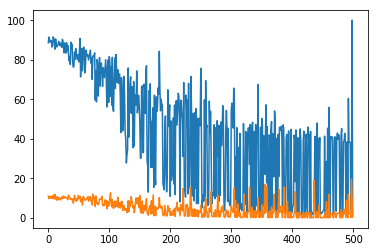

In [13]:
num_neurons = 10
learning_rate = 0.001
w = np.random.normal(0, 0.1, (num_neurons, num_neurons))
np.fill_diagonal(w, 0)
theta = np.random.normal(0, 0.1, (num_neurons,))

X_c = np.matrix([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])#np.random.binomial(1, 0.5, (100, num_neurons))
s1_c, s2_c = calculate_statistics(X_c)

q = []
for _ in range(500):
    X = generate_samples(w, theta, 100, 400)
    Z = calculate_normalizing_constant(X, w, theta)
    p = calculate_probabilities(X, w, theta, Z)

    p_repeat = np.tile(p, (num_neurons, 1)).T
    Q = np.multiply(p_repeat, X)
    s2 = np.dot(X.T, Q)
    s1 = np.dot(p, X)

    dLdtheta = s1_c - s1
    dLdw = s2_c - s2
    np.fill_diagonal(dLdw, 0)

    delta_w = learning_rate * dLdw
    delta_theta = learning_rate * np.squeeze(np.asarray(dLdtheta))

    w += delta_w
    theta += delta_theta

    print([np.sum(np.abs(dLdw)), np.sum(np.abs(dLdtheta))])
    q.append([np.sum(np.abs(dLdw)), np.sum(np.abs(dLdtheta))])
    
plt.plot(q)

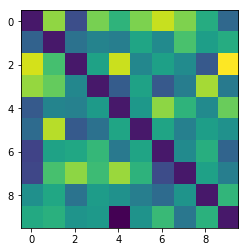

In [14]:
plt.imshow(t)

In [15]:
w, theta

(array([[ 0.        ,  0.4060814 ,  0.09254595,  0.38471129,  0.30987092,
          0.39009907,  0.44842169,  0.39214082,  0.29207054,  0.14493207],
        [ 0.1329786 ,  0.        ,  0.16502634,  0.20119019,  0.19161021,
          0.27626193,  0.21826793,  0.34250131,  0.26155215,  0.29242386],
        [ 0.45938689,  0.3385294 ,  0.        ,  0.27060163,  0.45068578,
          0.21015608,  0.26587543,  0.22013092,  0.11259491,  0.49373769],
        [ 0.41010391,  0.36861707,  0.20966779,  0.        ,  0.12058161,
          0.27054586,  0.1128865 ,  0.19054601,  0.42327141,  0.18132857],
        [ 0.1152895 ,  0.20458438,  0.19832807,  0.25388915,  0.        ,
          0.24719908,  0.40435919,  0.31010761,  0.21831948,  0.3733484 ],
        [ 0.15143607,  0.43725293,  0.11495472,  0.16274129,  0.27659026,
          0.        ,  0.27414557,  0.1950532 ,  0.26170306,  0.23332053],
        [ 0.07313935,  0.26953533,  0.28026392,  0.31785436,  0.17990475,
          0.27489509,  0.       

In [35]:
generate_samples(w, theta, 50, 10)

array([[ 1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.],
       [ 1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.],
       [ 1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.],
       [ 1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.],
       [ 1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.],
       [-1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.],
       [-1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.],
       [-1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.]])